# Traffic sign recongtion project

#### By Yaozhong Zhang  July 12, 2018

## Load data and visualize data

In [1]:
import pickle

training_file = "train.p"
validation_file = "valid.p"
testing_file = "test.p"

with open(training_file,mode='rb') as f:
    train = pickle.load(f)
with open(validation_file,mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file,mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'],test['labels']

In [2]:
# Provide a basic summary of the data set

n_train = len(X_train)
n_validation = len(X_valid)
n_test = len(X_test)

image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


10


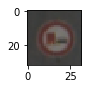

In [3]:
# visualize data

import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

## Pre-process and model architecture

In [4]:
# normalization!!!!!!!!!

X_train = (np.float32(X_train)-128)/128
X_valid = (np.float32(X_valid)-128)/128
X_test = (np.float32(X_test)-128)/128

#print(X_train[0])

In [5]:
# shuffle the training data

from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

In [26]:
# set up TensorFlow
import tensorflow as tf

EPOCHS = 8
BATCH_SIZE = 128

In [73]:
# Implement LeNet-5

"""
Architecture
Layer 1: Convolutional. The output shape should be 28x28x6.

Activation. Your choice of activation function.

Pooling. The output shape should be 14x14x6.

Layer 2: Convolutional. The output shape should be 10x10x16.

Activation. Your choice of activation function.

Pooling. The output shape should be 5x5x16.

Flatten. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using tf.contrib.layers.flatten, which is already imported for you.

Layer 3: Fully Connected. This should have 120 outputs.

Activation. Your choice of activation function.

Layer 4: Fully Connected. This should have 84 outputs.

Activation. Your choice of activation function.

Layer 5: Fully Connected (Logits). This should have 10 outputs.
"""

from tensorflow.contrib.layers import flatten

def LeNet(x,keep_prob):
    
    global fc3_W
    global conv1_W
    global conv1
    global fc3
    
    mu = 0
    sigma = 0.11
    #Layer 1 convolutional Input 32x32x3
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5,5,3,6),mean= mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x,conv1_W,strides = [1,1,1,1],padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1,conv1_b)
    
    conv1 = tf.nn.relu(conv1)
    
    #Pooling Input 28x28x6
    conv1 = tf.nn.max_pool(conv1,ksize = [1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    
    #Layer 2 convolutional Input 14x14x6
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1,conv2_W,strides = [1,1,1,1],padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2,conv2_b)
    
    conv2 = tf.nn.relu(conv2)
    
    #Pooling Input 10x10x16
    conv2 = tf.nn.max_pool(conv2,ksize=[1,2,2,1],strides=[1,2,2,1],padding = 'SAME')
    
    #Flatten Input 5x5x16
    flat = flatten(conv2)
    
    #Layer 3 Fully connectted Input 400
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(flat,fc1_W) + fc1_b
    
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1,keep_prob)
    
    #Layer 4 Fully connectted Input 120
    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(84))
    fc2 = tf.matmul(fc1,fc2_W) + fc2_b
    
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2,keep_prob)
    
    #Layer 5 Fully connectted Input 84
    fc3_W = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b = tf.Variable(tf.zeros(43))
    fc3 = tf.matmul(fc2,fc3_W) + fc3_b
    
    logits = fc3
    
    return logits
    
    

In [74]:
# set features and labels

x = tf.placeholder(tf.float32,(None,32,32,3))
y = tf.placeholder(tf.int32,(None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y,43)

In [75]:
# training pipeline

rate = 0.0008

logits = LeNet(x,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels = one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [76]:
# Model Evaluation

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

Training...

EPOCH 1 ...
Validation Accuracy = 0.520

EPOCH 2 ...
Validation Accuracy = 0.711

EPOCH 3 ...
Validation Accuracy = 0.798

EPOCH 4 ...
Validation Accuracy = 0.847

EPOCH 5 ...
Validation Accuracy = 0.869

EPOCH 6 ...
Validation Accuracy = 0.889

EPOCH 7 ...
Validation Accuracy = 0.888

EPOCH 8 ...
Validation Accuracy = 0.893



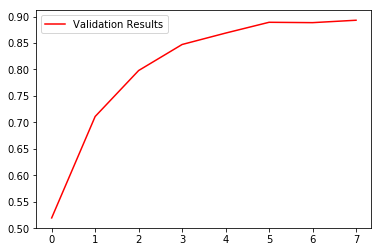

Model saved


In [77]:
# Train the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    
    valid_results = []
    
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:0.5})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        valid_results.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    plt.plot(np.arange(0,EPOCHS), valid_results, '-r', label='Validation Results')
    plt.legend(loc='upper left')
    plt.show()
    
    saver.save(sess, './lenet')
    print("Model saved")

In [78]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from .\lenet
Test Accuracy = 0.910


## Test model on new images

This image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)
This image is: <class 'numpy.ndarray'> with dimensions: (32, 32, 3)


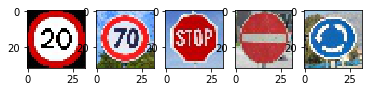

In [79]:
# load and output the images and pre-process
import matplotlib.image as mpimg

def read_and_print_image(image_path):
    #reading in an image
    image = mpimg.imread(image_path)
    #printing out some stats and plotting
    print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image
    return image

X_new_1 = read_and_print_image('image_1.jpg')
X_new_2 = read_and_print_image('image_2.jpg')
X_new_3 = read_and_print_image('image_3.jpg')
X_new_4 = read_and_print_image('image_4.jpg')
X_new_5 = read_and_print_image('image_5.jpg')
X_new = (X_new_1, X_new_2, X_new_3, X_new_4, X_new_5)
fig = plt.figure()
i=0
X_new_processed = []
for X in X_new:
    i+=1
    fig.add_subplot(1,len(X_new),i)
    plt.imshow(X)
    X = (np.float32(X)-128)/128
    X = X.reshape(1, 32, 32,3)
    X_new_processed.append(X)
    
# Image 1: label 0
# Image 2: label 4
# Image 3: label 14
# Image 4: label 17
# Image 5: label 40

y_new = [0,4,14,17,40]

In [80]:
# predict the sign type for each iamge
num = 5

predict_type = tf.argmax(logits, 1)
top_five_types = tf.nn.top_k(tf.nn.softmax(logits), k=num)
results_predict_type = []
results_top_five_types = []

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    sess = tf.get_default_session()
    i=0
    for X in X_new_processed:
        i+=1
        new = sess.run(predict_type, feed_dict={x: X, keep_prob: 1.0})
        results_predict_type.append(new)
        new = sess.run(top_five_types, feed_dict={x: X, keep_prob: 1.0})
        results_top_five_types.append(new)
        
# Analyze performance
count = 0
for i in range(len( results_predict_type)):
    print('Image {}:'.format(i+1))
    print('Predicted Type: {}, True Type: {}'.format( results_predict_type[i][0],y_new[i]))
    if  results_predict_type[i][0]==y_new[i]:
        count += 1
        
print('Correctly Predicted {} out of {}. Accuracy is {}%'.format(count, len( results_predict_type),\
                                                                 float(count)/len( results_predict_type)*100))

# Top 5 Softmax Probabilities For Each Image Found on the Web

for i in range(num):
    print('\nImage {}:'.format(i+1))
    print('Top Five Probabilities: {}'.format( results_top_five_types[i][0]))
    print('Top Five Possible Types: {}'.format( results_top_five_types[i][1]))

INFO:tensorflow:Restoring parameters from .\lenet
Image 1:
Predicted Type: 1, True Type: 0
Image 2:
Predicted Type: 3, True Type: 4
Image 3:
Predicted Type: 14, True Type: 14
Image 4:
Predicted Type: 17, True Type: 17
Image 5:
Predicted Type: 40, True Type: 40
Correctly Predicted 3 out of 5. Accuracy is 60.0%

Image 1:
Top Five Probabilities: [[8.8349313e-01 9.6058883e-02 2.0154476e-02 2.1715208e-04 3.6928650e-05]]
Top Five Possible Types: [[1 2 0 4 5]]

Image 2:
Top Five Probabilities: [[0.527598   0.37595138 0.06615262 0.025632   0.00393885]]
Top Five Possible Types: [[ 3 15  4  5  2]]

Image 3:
Top Five Probabilities: [[1.0000000e+00 5.4485416e-09 4.5764767e-11 2.1774417e-11 1.3281271e-11]]
Top Five Possible Types: [[14 17 22 29 13]]

Image 4:
Top Five Probabilities: [[9.7850651e-01 2.1493327e-02 5.9684766e-08 2.0161069e-08 6.1064473e-09]]
Top Five Possible Types: [[17 14 22  0 13]]

Image 5:
Top Five Probabilities: [[9.9973768e-01 2.5218778e-04 9.1417360e-06 9.3503672e-07 1.6930665

In [81]:
# Visualise the network's feature maps

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input  = (np.float32(image_input)-128)/128
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

In [85]:
outputFeatureMap(X_new_3, conv1, activation_min=-1, activation_max=-1 ,plt_num=1)

RuntimeError: Attempted to use a closed Session.